In [42]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [49]:
data= pd.read_csv("/Users/jigneshjadhav/Downloads/AEP_hourly.csv", index_col=[0], parse_dates=[0])
data

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


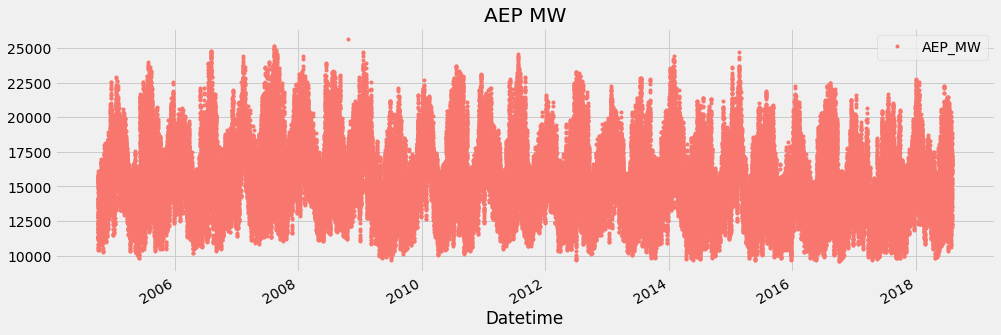

In [50]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
plot_x = data.plot(style='.', figsize=(15,5), color=color_pal[0], title='AEP MW')

# Train Test Split 

Cut off the data after 2014 to use as our validation set.

In [51]:
split_date = '01-Jan-2014'
df_train = data.loc[data.index <= split_date].copy()
df_test = data.loc[data.index > split_date].copy()

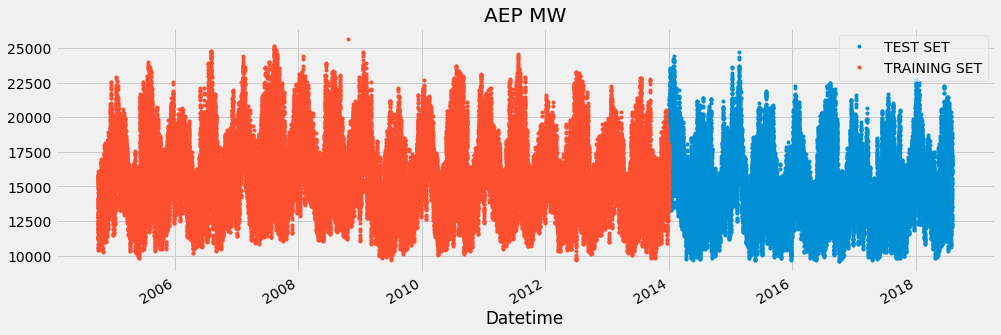

In [52]:
_ = df_test.rename(columns={'AEP_MW': 'TEST SET'})\
.join(df_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer') \
.plot(figsize=(15,5), title='AEP MW', style='.')

# CREATE TIME SERIES FEATURES

In [53]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [54]:
X_train, y_train = create_features(df_train, label='AEP_MW')
X_test, y_test = create_features(df_test, label='AEP_MW')

<ipython-input-53-568ff9107aea>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


# Create XGBoost model

In [56]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:11263.35059	validation_1-rmse:10407.06348
[1]	validation_0-rmse:7958.16602	validation_1-rmse:7144.47461
[2]	validation_0-rmse:5666.92334	validation_1-rmse:4971.33154
[3]	validation_0-rmse:4092.69165	validation_1-rmse:3524.89795
[4]	validation_0-rmse:3026.50879	validation_1-rmse:2583.99170
[5]	validation_0-rmse:2319.27856	validation_1-rmse:2027.01648
[6]	validation_0-rmse:1854.08984	validation_1-rmse:1742.89099
[7]	validation_0-rmse:1580.06702	validation_1-rmse:1604.59937
[8]	validation_0-rmse:1392.85730	validation_1-rmse:1574.87183
[9]	validation_0-rmse:1290.93652	validation_1-rmse:1548.53247
[10]	validation_0-rmse:1218.08813	validation_1-rmse:1556.63721
[11]	validation_0-rmse:1187.13196	validation_1-rmse:1562.21265
[12]	validation_0-rmse:1155.31799	validation_1-rmse:1570.20850
[13]	validation_0-rmse:1125.43323	validation_1-rmse:1565.05298
[14]	validation_0-rmse:1102.33008	validation_1-rmse:1570.76782
[15]	validation_0-rmse:1092.40625	validation_1-rmse:1577.55102


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Feature Importances

Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

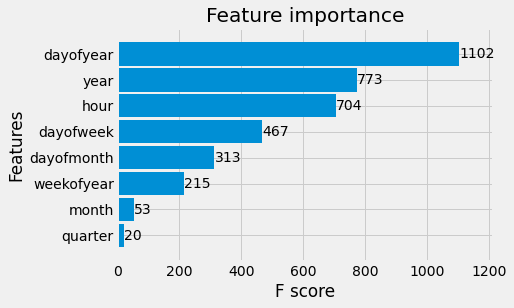

In [17]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [19]:
df_test['MW_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

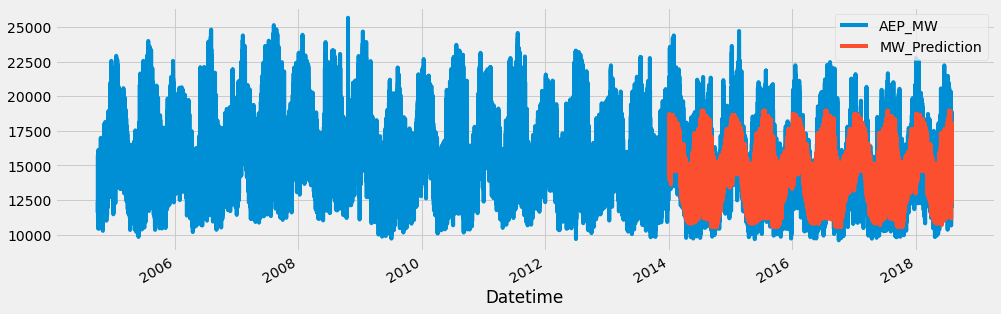

In [20]:
_ = df_all[['AEP_MW','MW_Prediction']].plot(figsize=(15, 5))


# Look at first month of predictions

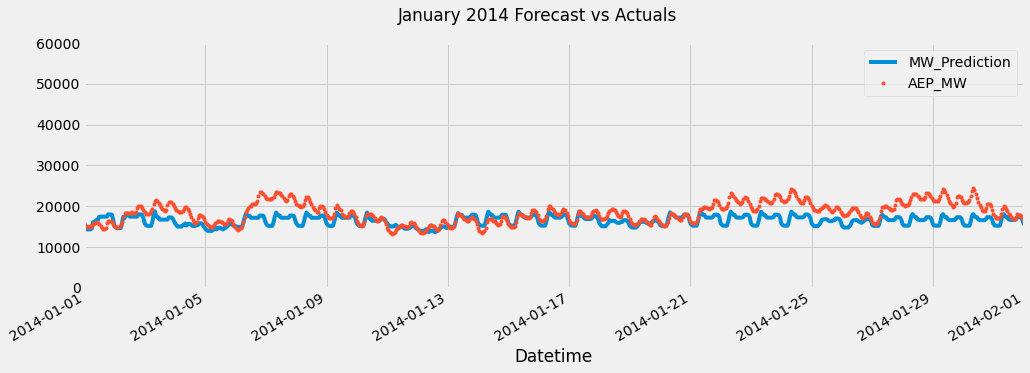

In [39]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2014', upper='02-01-2014')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2014 Forecast vs Actuals')

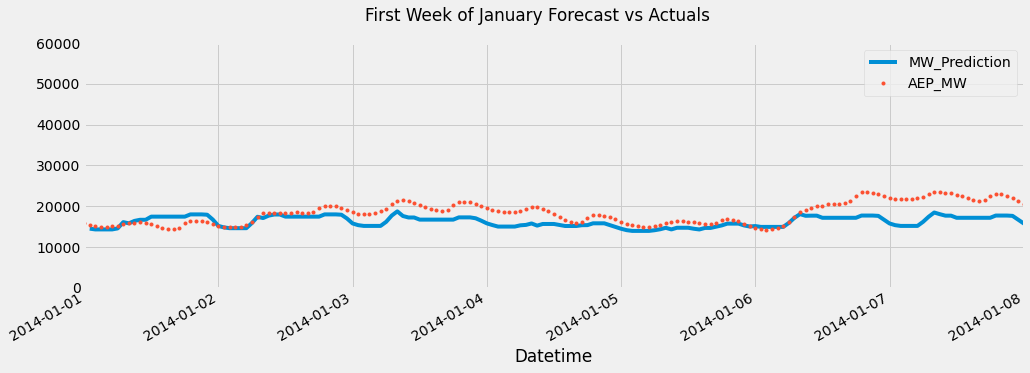

In [40]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2014', upper='01-08-2014')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

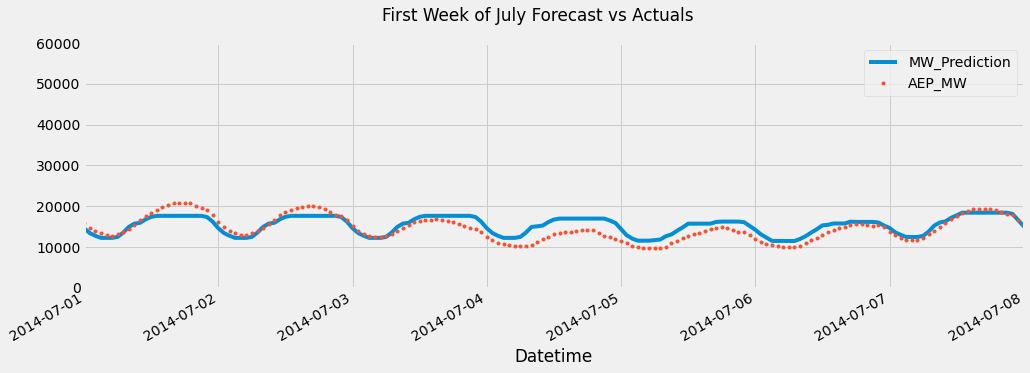

In [41]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2014', upper='07-08-2014')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Error Metrics On Test Set 

In [25]:
mean_squared_error(y_true=df_test['AEP_MW'],
                   y_pred=df_test['MW_Prediction'])

2397953.7756357193

In [26]:
mean_absolute_error(y_true=df_test['AEP_MW'],
                   y_pred=df_test['MW_Prediction'])

1183.5417123957116

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
mean_absolute_percentage_error(y_true=df_test['AEP_MW'],
                   y_pred=df_test['MW_Prediction'])

7.8330148821901595

# Worst and Best Days predicted

In [31]:
df_test['error'] = df_test['AEP_MW'] - df_test['MW_Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth']) \
    .mean()[['AEP_MW','MW_Prediction','error','abs_error']]

In [32]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 12    24          11466.041667   15760.211914 -4294.170125  4294.170125
           25          11078.041667   15343.193359 -4265.151978  4265.151978
2016 7     4           12048.000000   15865.010742 -3817.010661  3817.010661
2017 1     22          12295.541667   15756.479492 -3460.937948  3460.937948
     2     12          12408.791667   15864.607422 -3455.815470  3455.815470
2015 11    26          11718.500000   15037.200195 -3318.699870  3318.699870
2016 12    26          12242.375000   15558.558594 -3316.183268  3316.183268
2017 1     2           13478.583333   16644.126953 -3165.544189  3165.544189
     2     19          12189.541667   15312.434570 -3122.893188  3122.893188
2018 2     25          12331.875000   15443.532227 -3111.657064  3111.657064

In [33]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 2     20          22047.041667   16306.370117  5740.671183  5740.671183
           19          22249.500000   16511.652344  5737.847290  5737.847290
2018 1     6           20847.833333   15331.564453  5516.268840  5516.268840
2014 1     7           22319.166667   16867.031250  5452.134806  5452.134806
           28          21910.875000   16595.378906  5315.496948  5315.496948
           29          21872.125000   16595.378906  5276.746948  5276.746948
2018 1     7           19803.375000   14639.714844  5163.660482  5163.660482
2015 1     8           21873.333333   16867.031250  5006.301473  5006.301473
2014 1     24          22002.416667   17030.728516  4971.688680  4971.688680
2015 2     16          21129.791667   16471.390625  4658.400228  4658.400228

In [34]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

,,,AEP_MW,MW_Prediction,error,abs_error
year,month,dayofmonth,,,,
2018,8,3,14809.000000,14718.658203,90.341797,90.341797
2015,1,23,16982.875000,17030.728516,-47.852987,189.753703
2016,2,17,16549.083333,16511.652344,37.430623,192.263143
2015,1,22,16919.291667,17010.521484,-91.229858,213.392863
2014,10,21,14048.833333,13977.567383,71.265828,241.890015
2018,2,4,15846.791667,15859.317383,-12.525757,242.098674
2014,1,20,16927.916667,16940.460938,-12.544393,250.762655
2017,11,9,14671.750000,14610.626953,61.122599,251.094035
2014,10,13,13515.833333,13677.837891,-162.004720,251.407715


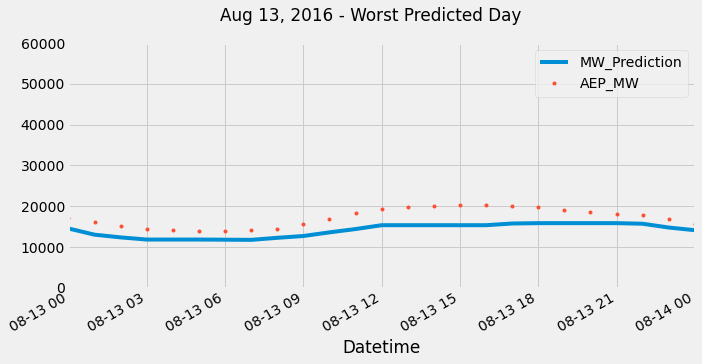

In [35]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

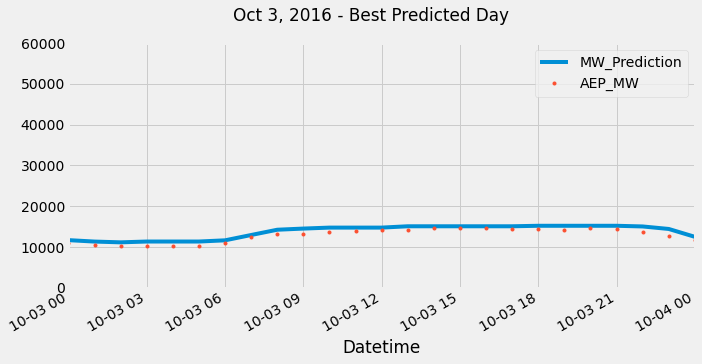

In [36]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

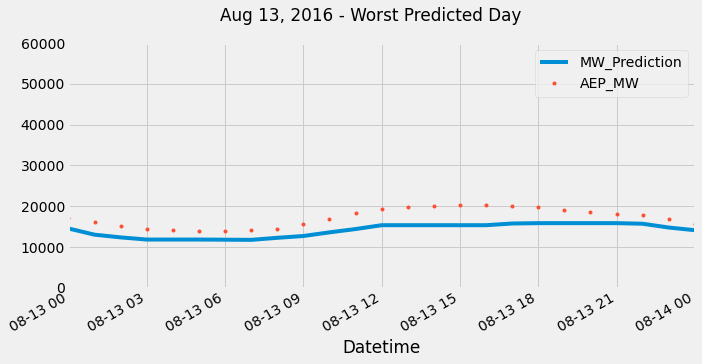

In [37]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')